In [50]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, ReLU, Conv2D

from tensorflow.nn import conv2d, conv2d_transpose
from tensorflow.io import read_file
from tensorflow.image import decode_image

import sys

### Helpers

In [3]:
def _conv2d(x, kernel):
    return conv2d(x, kernel, strides=[1, 2, 2, 1], padding='SAME')

def _conv2d_transpose(x, kernel, output_shape):
    return conv2d_transpose(
            x, kernel,
            output_shape=output_shape,
            strides=[1, 2, 2, 1],
            padding='SAME')

def load_image(image_path):
    image = read_file(image_path)
    image = decode_image(image)

    return image

In [4]:
class WaveletPooling(Layer):
    """
    Wavelet Pooing Custom Layer
    """
    def __init__(self, name=''):
        super(WaveletPooling, self).__init__()
        self._name = name
        square_of_2 = tf.math.sqrt(tf.constant(2, dtype=tf.float32))
        L = tf.math.divide(
            tf.constant(1, dtype=tf.float32),
            tf.math.multiply(square_of_2, tf.constant([[1, 1]], dtype=tf.float32))
        )
        H = tf.math.divide(
            tf.constant(1, dtype=tf.float32),
            tf.math.multiply(square_of_2, tf.constant([[-1, 1]], dtype=tf.float32))
        )

        self.LL = tf.reshape(tf.math.multiply(tf.transpose(L), L), (1, 2, 2, 1))
        self.LH = tf.reshape(tf.math.multiply(tf.transpose(L), H), (1, 2, 2, 1))
        self.HL = tf.reshape(tf.math.multiply(tf.transpose(H), L), (1, 2, 2, 1))
        self.HH = tf.reshape(tf.math.multiply(tf.transpose(H), H), (1, 2, 2, 1))

    def call(self, inputs):
        LL, LH, HL, HH = self.repeat_filters(inputs.shape[-1])
        return [_conv2d(inputs, LL),
                _conv2d(inputs, LH),
                _conv2d(inputs, HL),
                _conv2d(inputs, HH)]

    def compute_output_shape(self, input_shape):
        shape = (
            input_shape[0], input_shape[1] // 2,
            input_shape[2] // 2, input_shape[3]
        )

        return [shape, shape, shape, shape]

    def repeat_filters(self, repeats):
        # Can we optimize this?
        return [
            tf.transpose(tf.repeat(self.LL, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.LH, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.HL, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.HH, repeats, axis=0), (1, 2, 3, 0))
        ]

class WaveletUnpooling(Layer):
    """
    Wavelet Unpooing Custom Layer
    """
    def __init__(self, name):
        super(WaveletUnpooling, self).__init__()
        self._name = name
        square_of_2 = tf.math.sqrt(tf.constant(2, dtype=tf.float32))
        L = tf.math.divide(
            tf.constant(1, dtype=tf.float32),
            tf.math.multiply(square_of_2, tf.constant([[1, 1]], dtype=tf.float32))
        )
        H = tf.math.divide(
            tf.constant(1, dtype=tf.float32),
            tf.math.multiply(square_of_2, tf.constant([[-1, 1]], dtype=tf.float32))
        )

        self.LL = tf.reshape(tf.math.multiply(tf.transpose(L), L), (1, 2, 2, 1))
        self.LH = tf.reshape(tf.math.multiply(tf.transpose(L), H), (1, 2, 2, 1))
        self.HL = tf.reshape(tf.math.multiply(tf.transpose(H), L), (1, 2, 2, 1))
        self.HH = tf.reshape(tf.math.multiply(tf.transpose(H), H), (1, 2, 2, 1))

    def call(self, inputs):
        LL_in, LH_in, HL_in, HH_in, tensor_in = inputs
        LL, LH, HL, HH = self.repeat_filters(LL_in.shape[-1])
        out_shape = tf.shape(tensor_in)

        return _conv2d_transpose(LL_in, LL, output_shape=out_shape) + _conv2d_transpose(LH_in, LH, output_shape=out_shape) + _conv2d_transpose(HL_in, HL, output_shape=out_shape) + _conv2d_transpose(HH_in, HH, output_shape=out_shape)

    def compute_output_shape(self, input_shape):
        _ip_shape = input_shape[0]
        shape = (
            _ip_shape[0],
            _ip_shape[1] * 2,
            _ip_shape[2] * 2,
            sum(ips[3] for ips in input_shape)
        )

        return shape

    def repeat_filters(self, repeats):
        # Can we optimize this?
        return [
            tf.transpose(tf.repeat(self.LL, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.LH, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.HL, repeats, axis=0), (1, 2, 3, 0)),
            tf.transpose(tf.repeat(self.HH, repeats, axis=0), (1, 2, 3, 0)),
        ]

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [tf.keras.layers.InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        if s[1] == None:
            return (None, None, None, s[3])
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

    def get_config(self):
        config = super(ReflectionPadding2D, self).get_config()
        print(config)
        return config

class CNNBlock(Layer):
    def __init__(self, filters, kernel, name):
        super(CNNBlock, self).__init__()
        self._name = name
        
        self.padding = ReflectionPadding2D()
        self.conv2d = Conv2D(filters, kernel, padding = 'valid')
        self.activation = ReLU()

    def call(self, inputs):
        x = self.padding(inputs)
        x = self.conv2d(x)
        x = self.activation(x)
        
        return x

In [119]:
def preprocess_feat(feat, center = False):
    feat = tf.reshape(feat, (-1, feat.shape[-1]))
    feat = tf.transpose(feat)
    
    feat_mean = tf.math.reduce_mean(feat, 1)
    
    if center:
        feat_mean = tf.expand_dims(feat_mean, 1)
        feat = tf.subtract(feat, feat_mean)
        
    return feat,feat_mean

def center_feat(feat):
    feat_mean = tf.math.reduce_mean(feat, 1)
    feat_mean = tf.expand_dims(feat_mean, 1)
    return tf.subtract(feat, feat_mean)

def get_svd(feat):
    feat = center_feat(feat)
    feat = tf.matmul(feat, feat, transpose_b=True) / (feat.shape[1] - 1)
    feat = feat + tf.eye(feat.shape[0])
    
    return tf.linalg.svd(feat)

def get_style_correlation_transform(feat, return_mean = False):
    feat, mean = preprocess_feat(feat)
    s_e, _, s_v = get_svd(feat)
    # The inverse of the content singular values matrix operation (^-0.5)
    s_e = tf.pow(s_e, 0.5)
    
    EDE = tf.matmul(tf.matmul(s_v, tf.linalg.diag(s_e)), s_v, transpose_b=True)
    return (EDE, mean) if return_mean else EDE

def wct(content_feat_raw, style_feat_raw, alpha = 1):
    style_EDE, style_mean = get_style_correlation_transform(style_feat_raw, return_mean = True)
    content_feat, content_mean = preprocess_feat(content_feat_raw, center=True)
    
    c_e, _, c_v = get_svd(content_feat)
    c_e = tf.pow(c_e, -0.5)
    
    content_EDE = tf.matmul(tf.matmul(c_v, tf.linalg.diag(c_e)), c_v, transpose_b=True)
    content_whitened = tf.matmul(content_EDE, content_feat)

    final_out = tf.matmul(style_EDE, content_whitened)
    final_out = tf.add(final_out, tf.expand_dims(style_mean, 1))
    final_out = tf.clip_by_value(
        final_out,
        tf.math.reduce_min(content_feat),
        tf.math.reduce_max(content_feat),
    )
    
    final_out = tf.reshape(tf.transpose(final_out), content_feat_raw.shape)
    final_out = alpha * final_out + (1 - alpha) * content_feat_raw
    return final_out

In [125]:
class WaveletEncoder(Model):
    def __init__(self):
        super().__init__()
        self._name = 'WaveletEncoder'
        
        self.preprocessing_conv2d = Conv2D(3, 1, padding = 'valid')
        
        ### Block 1
        self.block1_conv2d_1 = CNNBlock(64, 3, 'WE_block1_conv2d_1')
        self.block1_conv2d_2 = CNNBlock(64, 3, 'WE_block1_conv2d_2')
        self.block1_pooling = WaveletPooling('WE_block1_pooling')
        
        ### Block 2
        self.block2_conv2d_1 = CNNBlock(128, 3, 'WE_block2_conv2d_1')
        self.block2_conv2d_2 = CNNBlock(128, 3, 'WE_block2_conv2d_2')
        self.block2_pooling = WaveletPooling('WE_block2_pooling')
        
        ### Block 3
        self.block3_conv2d_1 = CNNBlock(256, 3, 'WE_block3_conv2d_1')
        self.block3_conv2d_2 = CNNBlock(256, 3, 'WE_block3_conv2d_2')
        self.block3_conv2d_3 = CNNBlock(256, 3, 'WE_block3_conv2d_3')
        self.block3_conv2d_4 = CNNBlock(256, 3, 'WE_block3_conv2d_4')
        self.block3_pooling = WaveletPooling('WE_block3_pooling')
        
        ### Block 4
        self.block4_conv2d_1 = CNNBlock(512, 3, 'WE_block4_conv2d_1')

    def call(self, inputs, style_feat = None, trainable = False):
        wavelet_skips = {
            'block1': None,
            'block2': None,
            'block3': None,
        }
        
        features = {
            'block1': None,
            'block2': None,
            'block3': None
        }
        
        x = self.preprocessing_conv2d(inputs)
        
        x = self.block1_conv2d_1(x)
        x = self.block1_conv2d_2(x)
        LL_1, LH_1, HL_1, HH_1 = self.block1_pooling(x)
        wavelet_skips['block1'] = [LH_1, HL_1, HH_1, x]
        features['block1'] = LL_1
        
        if style_feat:
            LL_1 = tf.map_fn(
                lambda x: wct(x[0], x[1]),
                (LL_1, style_feat['block1']),
                dtype=LL_1.dtype
            )
            
        x = self.block2_conv2d_1(LL_1)
        x = self.block2_conv2d_2(x)
        LL_2, LH_2, HL_2, HH_2 = self.block2_pooling(x)
        wavelet_skips['block2'] = [LH_2, HL_2, HH_2, x]
        features['block2'] = LL_2
        
        if style_feat:
            LL_2 = tf.map_fn(
                lambda y: wct(y[0], y[1]),
                (LL_2, style_feat['block2']),
                dtype=LL_2.dtype
            )
            
        x = self.block3_conv2d_1(LL_2)
        x = self.block3_conv2d_2(x)
        x = self.block3_conv2d_3(x)
        x = self.block3_conv2d_4(x)
        LL_3, LH_3, HL_3, HH_3 = self.block3_pooling(x)
        wavelet_skips['block3'] = [LH_3, HL_3, HH_3, x]
        features['block3'] = LL_3
        
        if style_feat:
            LL_3 = tf.map_fn(
                lambda x: wct(x[0], x[1]),
                (LL_3, style_feat['block3']),
                dtype=LL_3.dtype
            )
        
        x = self.block4_conv2d_1(LL_3)
        features['block4'] = x
        
        if style_feat:
            x = tf.map_fn(
                lambda x: wct(x[0], x[1]),
                (x, style_feat['block4']),
                dtype=x.dtype
            )
            
        return x, wavelet_skips, features
    
class WaveletDecoder(Model):
    def __init__(self):
        super().__init__()
        self._name = 'WaveletDecoder'

        ### Block 3
        self.block3_conv2d_1 = CNNBlock(256, 3, 'WD_block4_conv2d_1')
        self.block3_unpooling = WaveletUnpooling('WD_block4_unpooling')
        self.block3_conv2d_2 = CNNBlock(256, 3, 'WD_block3_conv2d_2')
        self.block3_conv2d_3 = CNNBlock(256, 3, 'WD_block3_conv2d_3')
        self.block3_conv2d_4 = CNNBlock(256, 3, 'WD_block3_conv2d_4')

        ### Block 2
        self.block2_conv2d_1 = CNNBlock(128, 3, 'WE_block2_conv2d_1')
        self.block2_unpooling = WaveletUnpooling('WE_block2_unpooling')
        self.block2_conv2d_2 = CNNBlock(128, 3, 'WE_block2_conv2d_2')

        ### Block 1
        self.block1_conv2d_1 = CNNBlock(64, 3, 'WE_block1_conv2d_1')
        self.block1_unpooling = WaveletUnpooling('WE_block1_unpooling')
        self.block1_conv2d_2 = CNNBlock(64, 3, 'WE_block1_conv2d_2')

        self.post_processing_padding = ReflectionPadding2D()
        self.post_processing_conv2d = Conv2D(3, 3, padding = 'valid')

    def call(self, inputs, skips, trainable = False):
        features = {
            'block3': None,
            'block2': None,
            'block1': None,
        }
        
        x = self.block3_conv2d_1(inputs)
        x = self.block3_unpooling([x, *skips['block3']])
        x = self.block3_conv2d_2(x)
        x = self.block3_conv2d_3(x)
        x = self.block3_conv2d_4(x)
        features['block3'] = x
        
        x = self.block2_conv2d_1(x)
        x = self.block2_unpooling([x, *skips['block2']])
        x = self.block2_conv2d_2(x)
        features['block2'] = x

        x = self.block1_conv2d_1(x)
        x = self.block1_unpooling([x, *skips['block1']])
        x = self.block1_conv2d_2(x)
        features['block1'] = x

        x = self.post_processing_padding(x)
        x = self.post_processing_conv2d(x)

        return x, features

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


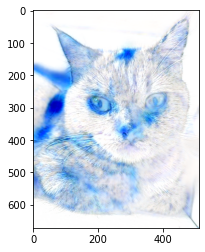

In [130]:
class WaveletAE(Model):
    def __init__(self):
        super().__init__()
        self._name = 'WaveletAE'
        self.encoder = WaveletEncoder()
        self.decoder = WaveletDecoder()
        self.load_weights('../weights/wavelet_autoencoder')

    def call(self, inputs, trainable = False):
        x, skips, _ = self.encoder(inputs)
        output, _ = self.decoder(x, skips)

        return output
        
    def transfer(self, content_img, style_img):
        style_features, style_skips = self.get_features(style_img)
        x, content_skips, _ = self.encoder(content_img, style_features['encoder'])
        
        for key in content_skips.keys():
            for i in range(3):
                content_skips[key][0] = tf.map_fn(
                    lambda x: wct(x[0], x[1]),
                    (content_skips[key][0], style_skips[key][0]),
                    dtype=tf.float32
                )
                
        out, _ = self.decoder(x, content_skips)
        return out
    
    def get_features(self, inputs):
        encoder_out, skips, encoder_feat = self.encoder(inputs)
        _, decoder_feat = self.decoder(encoder_out, skips)
        
        features = {
            'encoder': encoder_feat,
            'decoder': decoder_feat,
        }
        
        return features, skips
        
test_img = tf.io.read_file('../assets/moli_content.jpg')
test_img = tf.image.decode_image(test_img) / 255

test_img_style = tf.io.read_file('../assets/moli_style.jpg')
test_img_style = tf.image.decode_image(test_img_style) / 255

wavelet_ae = WaveletAE()
test_img_y = wavelet_ae.transfer(tf.expand_dims(test_img, 0), tf.expand_dims(test_img_style, 0))
plt.imshow(test_img_y[0])

In [61]:
features['encoder']['block1'][0, 0, 0]

<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([0.        , 0.76102895, 0.        , 0.48222587, 0.5296792 ,
       0.47904286, 0.5047952 , 0.        , 0.        , 0.6203614 ,
       0.        , 3.535949  , 0.8282799 , 1.0315491 , 3.663717  ,
       0.9836194 , 0.        , 0.4681163 , 4.7553406 , 0.        ,
       0.13054453, 0.        , 0.        , 2.4462757 , 0.        ,
       3.1718757 , 0.26564693, 0.        , 0.51951075, 0.        ,
       0.        , 7.0537777 , 0.4233733 , 0.56240785, 2.084407  ,
       0.11859917, 0.8840142 , 0.37998345, 0.        , 1.6034523 ,
       0.30039603, 0.49259186, 0.2748447 , 1.6242876 , 0.13898624,
       4.5140777 , 0.9028575 , 0.        , 0.        , 4.7894425 ,
       0.        , 1.1332467 , 0.6042512 , 0.4432713 , 2.8968127 ,
       0.02233037, 0.2022288 , 0.        , 0.14330062, 1.6452872 ,
       3.0449712 , 5.172212  , 0.        , 0.        ], dtype=float32)>